In [1]:
import keras
from keras.models import load_model, model_from_json

Using TensorFlow backend.


In [2]:
import tensorflow as tf

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tf.contrib.distributions.Multinomial(total_count=counts_per_example,
                                                logits=logits)
    return -tf.reduce_sum(dist.log_prob(true_counts)) / tf.to_float(tf.shape(true_counts)[0])


class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

from keras.utils import CustomObjectScope
from keras.models import load_model
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
    keras_model = load_model("model.h5")

W0709 10:19:56.774385 140668741826368 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 10:19:56.822966 140668741826368 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 10:19:57.504911 140668741826368 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0709 10:19:57.505913 140668741826368 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:184: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto i

In [3]:
keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq (InputLayer)                (None, 1000, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1000, 64)     6464        seq[0][0]                        
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1000, 64)     12352       conv1d_1[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, 1000, 64)     0           conv1d_1[0][0]                   
                                                                 conv1d_2[0][0]                   
__________

In [4]:
def get_out_tensor(inp_tensor, layer_to_copy, param_overrides={}):
    new_config = dict(layer_to_copy.get_config().items())
    for param_name in param_overrides:
        assert param_name in new_config
        new_config[param_name] = param_overrides[param_name]
    new_layer = layer_to_copy.__class__.from_config(new_config)
    adjusted_input_shape = list(layer_to_copy.input_shape)
    assert len(adjusted_input_shape)==3
    adjusted_input_shape[1] = None #flexible input len for convs
    adjusted_input_shape = tuple(adjusted_input_shape)
    new_layer.build(adjusted_input_shape)
    new_layer.set_weights(layer_to_copy.get_weights())
    out_tensor = new_layer(inp_tensor)
    return out_tensor

In [5]:
inp_tensor = keras.layers.Input((None,4))

conv1_out = get_out_tensor(inp_tensor=inp_tensor,
                           layer_to_copy=keras_model.layers[1],
                           param_overrides={'padding': 'same'})
conv2_out = get_out_tensor(inp_tensor=conv1_out,
                           layer_to_copy=keras_model.layers[2],
                           param_overrides={'padding': 'same'})
add_out = keras.layers.Add()([conv1_out, conv2_out])

convs = [conv1_out, conv2_out]

for i in range(8):
    conv_out = get_out_tensor(inp_tensor=add_out,
                              layer_to_copy=keras_model.layers[4 + 2*i],
                              param_overrides={'padding': 'same'})
    convs.append(conv_out)
    add_out = keras.layers.Add()([add_out, conv_out])

gaps = [keras.layers.GlobalAveragePooling1D()(x) for x in convs]

#conv3_out =  get_out_tensor(inp_tensor=add1_out,
#                            layer_to_copy=keras_model.layers[4],
#                            param_overrides={'padding': 'same'})
#add2_out = keras.layers.Add()([add1_out, conv3_out])
#conv4_out =  get_out_tensor(inp_tensor=add2_out,
#                            layer_to_copy=keras_model.layers[6],
#                            param_overrides={'padding': 'same'})
#add3_out = keras.layers.Add()([add2_out, conv4_out])
#conv5_out =  get_out_tensor(inp_tensor=add3_out,
#                            layer_to_copy=keras_model.layers[8],
#                            param_overrides={'padding': 'same'})

#conv1_gap = keras.layers.GlobalAveragePooling1D()(conv1_out)
#conv2_gap = keras.layers.GlobalAveragePooling1D()(conv2_out)
#conv3_gap = keras.layers.GlobalAveragePooling1D()(conv3_out)
#conv4_gap = keras.layers.GlobalAveragePooling1D()(conv4_out)

concat = keras.layers.Concatenate(axis=-1)(gaps)
embedding_model = keras.models.Model(inputs=inp_tensor, outputs=concat)

In [6]:
embedding_model.save("embedding_model.h5")

In [7]:
import numpy as np
embedding_model.predict(np.random.random((10, 41, 4))).shape

(10, 640)

In [8]:
embedding_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     6464        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 64)     12352       conv1d_1[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, None, 64)     0           conv1d_1[0][0]                   
                                                                 conv1d_2[0][0]                   
__________

In [9]:
import numpy as np
import h5py

f = h5py.File("/oak/stanford/groups/akundaje/avsec/basepair/data/"
              +"processed/comparison/output/nexus,peaks,OSNK,0,10"
              +",1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE"
              +",FALSE,1/deeplift.imp_score.h5", "r")
#f = h5py.File("/users/avanti/deeplift.imp_score.h5","r")
nanog_mask = np.array(f['metadata']['interval_from_task'][:]=='Nanog')
nanog_profile_wn_hypimp = np.array(f["hyp_imp/Nanog/profile/wn"][:])[nanog_mask]
onehot_seq = np.array(f["inputs/seq"][:])[nanog_mask]
nanog_profile_wn_contribs = nanog_profile_wn_hypimp*onehot_seq

In [10]:
nanog_profile_wn_contribs.shape

(55233, 1000, 4)

In [11]:
#print modisco commit hash
%cd /users/avanti/tfmodisco
!git log -n 1
%cd /users/avanti/tfmodisco_bio_experiments/bpnet/trial1

from importlib import reload

/mnt/lab_data2/avanti/tfmodisco
commit deb9880ff8845bfcc3657a266e1a857059b31fd7 (HEAD -> dev2, origin/dev2)
Author: AvantiShri <avanti.shrikumar@gmail.com>
Date:   Fri Jun 19 11:26:57 2020 -0700

    support for sparse return
/mnt/lab_data2/avanti/tfmodisco_bio_experiments/bpnet/trial1


In [12]:
%matplotlib inline
import h5py
import numpy as np
import modisco
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.phenograph
reload(modisco.cluster.phenograph)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.cluster
reload(modisco.cluster)
import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.affinitymat.transformers
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

%matplotlib inline

TF-MoDISco is using the TensorFlow backend.


num seqs to use: 1104
On task Nanog_profile_wn
Computing windowed sums on original
Generating null dist
peak(mu)= 0.003840833756548818
Computing threshold
Thresholds from null dist were -0.0166471004486084  and  0.10157325863838196
Final raw thresholds are -0.0166471004486084  and  0.10157325863838196
Final transformed thresholds are -0.519914596273292  and  0.8223334442472642


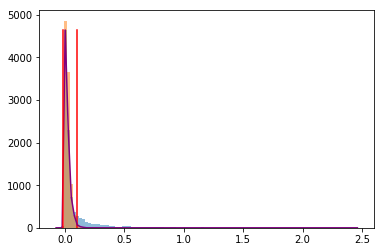

Got 9356 coords
After resolving overlaps, got 9356 seqlets
Across all tasks, the weakest transformed threshold used was: 0.519814596273292
MEMORY 3.324100608
9356 identified in total
Reducing weak_threshold_for_counting_sign to match weakest_transformed_thresh, from 0.8 to 0.519814596273292
2 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [8719, 637]
Idx to activities:  {0: '1', 1: '-1'}
MEMORY 3.324547072


In [13]:
import modisco
from collections import OrderedDict
import sys


def print_memory_use():
    import os
    import psutil
    process = psutil.Process(os.getpid())
    print("MEMORY",process.memory_info().rss/1000000000)

FRAC_SEQS_TO_USE = 0.02
NUM_SEQS_TO_USE = int(FRAC_SEQS_TO_USE*len(nanog_profile_wn_contribs))
print("num seqs to use:", NUM_SEQS_TO_USE)

task_names=["Nanog_profile_wn"]
contrib_scores={'Nanog_profile_wn':
                 nanog_profile_wn_contribs[:NUM_SEQS_TO_USE]}
hypothetical_contribs={'Nanog_profile_wn':
                       nanog_profile_wn_hypimp[:NUM_SEQS_TO_USE]}
one_hot=onehot_seq[:NUM_SEQS_TO_USE]
#null_tracks should either be a dictionary
# from task_name to 1d trakcs, or a callable
null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(
    num_to_samp=10000)
revcomp = True
plot_save_dir = "figures"

sliding_window_size = 21
flank_size = 10
histogram_bins = 100
percentiles_in_bandwidth = 10
overlap_portion = 0.5
min_metacluster_size = 100
min_metacluster_size_frac = 0.01
weak_threshold_for_counting_sign = 0.8
target_seqlet_fdr = 0.2
min_passing_windows_frac = 0.03
max_passing_windows_frac = 0.2
separate_pos_neg_thresholds = False
verbose = True
min_seqlets_per_task = None
other_tracks = []
#reducing from 50000 to 10000 for debugging purposes
max_seqlets_per_metacluster = 10000 #50000

overlap_resolver = modisco.core.SeqletsOverlapResolver(
    overlap_detector=modisco.core.CoordOverlapDetector(overlap_portion),
    seqlet_comparator=modisco.core.SeqletComparator(
       value_provider=
        modisco.value_provider.CoorScoreValueProvider()))

coord_producer = modisco.coordproducers.FixedWindowAroundChunks(
    sliding=sliding_window_size,
    flank=flank_size,
    suppress=(int(0.5*sliding_window_size)
              + flank_size),
    target_fdr=target_seqlet_fdr,
    min_passing_windows_frac=min_passing_windows_frac,
    max_passing_windows_frac=max_passing_windows_frac,
    separate_pos_neg_thresholds=separate_pos_neg_thresholds,
    max_seqlets_total=None,
    verbose=verbose,
    plot_save_dir=plot_save_dir) 

track_set = (modisco.tfmodisco_workflow.workflow.prep_track_set(
    task_names=task_names,
    contrib_scores=contrib_scores,
    hypothetical_contribs=hypothetical_contribs,
    one_hot=one_hot,
    revcomp=revcomp,
    other_tracks=other_tracks))

per_position_contrib_scores = OrderedDict([
    (x, [np.sum(s,axis=1) for s in contrib_scores[x]])
    for x in task_names])

multitask_seqlet_creation_results = modisco.core.MultiTaskSeqletCreator(
    coord_producer=coord_producer,
    overlap_resolver=overlap_resolver)(
        task_name_to_score_track=per_position_contrib_scores,
        null_tracks=null_per_pos_scores,
        track_set=track_set)

#find the weakest transformed threshold used across all tasks
weakest_transformed_thresh = (min(
    [min(x.tnt_results.transformed_pos_threshold,
         abs(x.tnt_results.transformed_neg_threshold))
         for x in (multitask_seqlet_creation_results.
                   task_name_to_coord_producer_results.values())]) -
    0.0001) #subtract 1e-4 to avoid weird numerical issues
print("Across all tasks, the weakest transformed threshold used"
      +" was: "+str(weakest_transformed_thresh))
print_memory_use()

all_seqlets = multitask_seqlet_creation_results.final_seqlets
print(str(len(all_seqlets))+" identified in total")
if (len(all_seqlets) < 100):
    print("WARNING: you found relatively few seqlets."
          +" Consider dropping target_seqlet_fdr") 

if int(min_metacluster_size_frac * len(all_seqlets)) > min_metacluster_size:
    print("min_metacluster_size_frac * len(seqlets) = {0} is more than min_metacluster_size={1}.".\
          format(int(min_metacluster_size_frac * len(all_seqlets)), min_metacluster_size))
    print("Using it as a new min_metacluster_size")
    min_metacluster_size = int(min_metacluster_size_frac * len(all_seqlets))

weak_threshold_for_counting_sign=0.8
if (weak_threshold_for_counting_sign is None):
    weak_threshold_for_counting_sign = weakest_transformed_thresh
else:
    weak_threshold_for_counting_sign =\
        weak_threshold_for_counting_sign
    
if (weak_threshold_for_counting_sign > weakest_transformed_thresh):
    print("Reducing weak_threshold_for_counting_sign to"
          +" match weakest_transformed_thresh, from "
          +str(weak_threshold_for_counting_sign)
          +" to "+str(weakest_transformed_thresh))
    weak_threshold_for_counting_sign = weakest_transformed_thresh

task_name_to_value_provider = OrderedDict([
    (task_name,
     modisco.value_provider.TransformCentralWindowValueProvider(
        track_name=task_name+"_contrib_scores",
        central_window=sliding_window_size,
        val_transformer= 
         coord_producer_results.tnt_results.val_transformer))
     for (task_name,coord_producer_results)
         in (multitask_seqlet_creation_results.
             task_name_to_coord_producer_results.items())])

min_metacluster_size=100
metaclusterer = modisco.metaclusterers.SignBasedPatternClustering(
                        min_cluster_size=min_metacluster_size,
                        task_name_to_value_provider=
                            task_name_to_value_provider,
                        task_names=task_names,
                        threshold_for_counting_sign=
                            weakest_transformed_thresh,
                        weak_threshold_for_counting_sign=
                            weak_threshold_for_counting_sign)

metaclustering_results = metaclusterer.fit_transform(all_seqlets)
metacluster_indices = np.array(
    metaclustering_results.metacluster_indices)
metacluster_idx_to_activity_pattern =\
    metaclustering_results.metacluster_idx_to_activity_pattern

num_metaclusters = max(metacluster_indices)+1
metacluster_sizes = [np.sum(metacluster_idx==metacluster_indices)
                      for metacluster_idx in range(num_metaclusters)]
if (verbose):
    print("Metacluster sizes: ",metacluster_sizes)
    print("Idx to activities: ",metacluster_idx_to_activity_pattern)
    print_memory_use()
    sys.stdout.flush()

In [14]:
metacluster_idx = 0
metacluster_size = metacluster_sizes[metacluster_idx]
print("On metacluster "+str(metacluster_idx))                       
if (max_seqlets_per_metacluster is None                        
    or max_seqlets_per_metacluster >= metacluster_size):       
    print("Metacluster size", metacluster_size)                     
else:                                                               
    print("Metacluster size {0} limited to {1}".format(             
            metacluster_size, max_seqlets_per_metacluster))    
sys.stdout.flush()                                                  
metacluster_activities = [                                          
    int(x) for x in                                                 
    metacluster_idx_to_activity_pattern[metacluster_idx].split(",")]
assert len(all_seqlets)==len(metacluster_indices)                       
metacluster_seqlets = [                                             
    x[0] for x in zip(all_seqlets, metacluster_indices)                 
    if x[1]==metacluster_idx][:max_seqlets_per_metacluster]    
relevant_task_names, relevant_task_signs =\
    zip(*[(x[0], x[1]) for x in                                     
        zip(task_names, metacluster_activities) if x[1] != 0])      
print('Relevant tasks: ', relevant_task_names)                      
print('Relevant signs: ', relevant_task_signs)                      
sys.stdout.flush()                                                  
if (len(relevant_task_names) == 0):                                 
    assert False, "This should not happen"                          
    sys.stdout.flush()                                              

onehot_track_name="sequence"
contrib_scores_track_names = [key+"_contrib_scores" for key in relevant_task_names]
hypothetical_contribs_track_names= [key+"_hypothetical_contribs" for key in relevant_task_names]                
track_signs=relevant_task_signs                              
other_comparison_track_names=[]

assert len(track_signs)==len(hypothetical_contribs_track_names)         
assert len(track_signs)==len(contrib_scores_track_names)                
                                                                                
seqlets_sorter = (lambda arr:                                           
                          sorted(arr,                                           
                                 key=lambda x:                                  
                                  -np.sum([np.sum(np.abs(x[track_name].fwd))    
                                     for track_name                             
                                     in contrib_scores_track_names])))

min_overlap_while_sliding = 0.7
pattern_comparison_settings =\
            modisco.affinitymat.core.PatternComparisonSettings(                         
                track_names=hypothetical_contribs_track_names                   
                            +contrib_scores_track_names                         
                            +other_comparison_track_names,                      
                track_transformer=modisco.affinitymat.L1Normalizer(),                   
                min_overlap=min_overlap_while_sliding)

#coarse_grained 1d embedder   
embedder_factory=(modisco.seqlet_embedding
                          .onehot_model_output.KerasModelOutputEmbedder
                          .get_factory(model_h5="embedding_model.h5"))
seqlets_to_1d_embedder = embedder_factory(                         
        onehot_track_name=onehot_track_name,                            
        toscore_track_names_and_signs=list(                             
        zip(hypothetical_contribs_track_names,                          
            [np.sign(x) for x in track_signs])))

#affinity matrix from embeddings                                        
coarse_affmat_computer =\
    modisco.affinitymat.core.AffmatFromSeqletEmbeddings(                        
        seqlets_to_1d_embedder=seqlets_to_1d_embedder,                  
        affinity_mat_from_1d=\
            modisco.affinitymat.core.NumpyCosineSimilarity(                     
                verbose=True,                                   
                gpu_batch_size=None),                                   
        verbose=True)                                           

affmat_from_seqlets_with_nn_pairs =\
    modisco.affinitymat.core.AffmatFromSeqletsWithNNpairs(                      
        pattern_comparison_settings=pattern_comparison_settings,        
        sim_metric_on_nn_pairs=\
            modisco.affinitymat.core.ParallelCpuCrossMetricOnNNpairs(           
                n_cores=10,                                   
                cross_metric_single_region=                             
                    modisco.affinitymat.core.CrossContinJaccardSingleRegion()))

seqlets = seqlets_sorter(metacluster_seqlets)
print("Computing coarse affmat", flush=True)
coarse_affmat = coarse_affmat_computer(seqlets)
print("Computing seqlet neighbors from coarse", flush=True)
seqlet_neighbors = (modisco.tfmodisco_workflow.seqlets_to_patterns
    .get_seqlet_neighbors_with_initcluster(       
        nearest_neighbors_to_compute=500,                         
        coarse_affmat=coarse_affmat,                                
        initclusters=None))
print("Computing fine-grained", flush=True)
affmat_from_seqlets_with_nn_pairs_argmax =\
    modisco.affinitymat.core.AffmatFromSeqletsWithNNpairs(
        pattern_comparison_settings=pattern_comparison_settings,
        sim_metric_on_nn_pairs=\
            modisco.affinitymat.core.ParallelCpuCrossMetricOnNNpairs(
                n_cores=10,
                cross_metric_single_region=
                    modisco.affinitymat.core.CrossContinJaccardSingleRegionWithArgmax()))

sparse_nn_affmat_withargmax = affmat_from_seqlets_with_nn_pairs_argmax(
    seqlet_neighbors=seqlet_neighbors,
    seqlets=seqlets,
    return_sparse=True)

On metacluster 0
Metacluster size 8719
Relevant tasks:  ('Nanog_profile_wn',)
Relevant signs:  (1,)
Computing coarse affmat
Beginning embedding computation


/users/avanti/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Finished embedding computation in 16.22 s
Starting affinity matrix computations
Normalization computed in 0.12 s
Cosine similarity mat computed in 1.29 s
Normalization computed in 0.07 s
Cosine similarity mat computed in 1.25 s
Finished affinity matrix computations in 3.51 s
Computing seqlet neighbors from coarse
Computing fine-grained
Launching nearest neighbors affmat calculation job
MEMORY 4.515622912
Parallel runs completed
MEMORY 4.637298688
Job completed in: 54.37 s
MEMORY 4.637978624
Launching nearest neighbors affmat calculation job
MEMORY 4.63773696
Parallel runs completed
MEMORY 4.716064768
Job completed in: 54.54 s
MEMORY 4.71627776


In [15]:
import scipy


def reconstitute_dense_affmat(sparse_affmat_withargmax, seqlet_neighbors):
    to_return = np.zeros((len(seqlet_neighbors), len(seqlet_neighbors)))
    for row_idx, (neighbors, affinitieswithargmax) in enumerate(zip(seqlet_neighbors, sparse_affmat_withargmax)):
        affinities = affinitieswithargmax[:,0]
        for col_idx, val in zip(neighbors, affinities):
            to_return[row_idx, col_idx] = val
    return to_return


def get_correlations(main_affmat, other_affmat):
    correlations = []
    for main_affmat_row, other_affmat_row\
        in zip(main_affmat, other_affmat):
        #compare correlation on the nonzero rows
        to_compare_mask = np.abs(main_affmat_row) > 0
        corr = scipy.stats.spearmanr(
                main_affmat_row[to_compare_mask],
                other_affmat_row[to_compare_mask])
        correlations.append(corr.correlation)
    correlations = np.array(correlations)
    return correlations


correlations = get_correlations(main_affmat=reconstitute_dense_affmat(
                                    sparse_affmat_withargmax=sparse_nn_affmat_withargmax,
                                    seqlet_neighbors=seqlet_neighbors),
                                other_affmat=coarse_affmat)

In [47]:
from modisco.visualization import viz_sequence


def max_window_sum(ic_vals, window_size=6):
    per_pos_tot_ic = np.sum(ic_vals, axis=-1)
    cumsum = np.cumsum([0]+list(per_pos_tot_ic))
    return np.max(cumsum[window_size:] - cumsum[:-window_size])


def get_aligned_coordinates_for_premotif(sparse_nn_affmat_withargmax_row,
                                         seqlet_neighbors_row,
                                         seqlets,
                                         num_in_premotif):
    #subset to the num_in_premotif most similar
    argsort_indices = np.argsort(-sparse_nn_affmat_withargmax_row[:,0])[:num_in_premotif]
    seqlet_indices = np.array([seqlet_neighbors_row[i] for i in argsort_indices])
    isfwd = sparse_nn_affmat_withargmax_row[:,2][argsort_indices]
    #flip sign of offset if on reverse strand
    offsets = (sparse_nn_affmat_withargmax_row[:,1][argsort_indices])*(2*isfwd - 1)
    coords_to_return = []
    for seqlet_idx,offset,isfwd in zip(seqlet_indices,offsets,isfwd):
        new_coor = modisco.core.SeqletCoordinates(
            example_idx=seqlets[seqlet_idx].coor.example_idx,
            start=int(seqlets[seqlet_idx].coor.start-offset),
            end=int(seqlets[seqlet_idx].coor.end-offset),
            #flip is_revcomp according to value of isfwd
            is_revcomp=(seqlets[seqlet_idx].coor.is_revcomp==(isfwd==1.0)))
        coords_to_return.append(new_coor)
    return coords_to_return


def get_premotif_avgonehot(datatrack, **kwargs):
    coords = get_aligned_coordinates_for_premotif(**kwargs)
    to_avg = []
    for coor in coords:
        if (coor.start >= 0 and
            coor.end <= len(datatrack.fwd_tracks[coor.example_idx])):
            to_avg.append(datatrack.get_snippet(coor=coor).fwd)
    return np.mean(to_avg, axis=0)


def get_premotif_avgseqlets(track_set, **kwargs):
    coords = get_aligned_coordinates_for_premotif(**kwargs)
    premotif = modisco.core.Pattern()
    for track_name, datatrack in track_set.track_name_to_data_track.items():
        fwd_to_avg = []
        rev_to_avg = []
        for coor in coords:
            if (coor.start >= 0 and
                coor.end <= len(datatrack.fwd_tracks[coor.example_idx])):
                fwd_to_avg.append(datatrack.get_snippet(coor=coor).fwd)
                rev_to_avg.append(datatrack.get_snippet(coor=coor).rev)
        fwd = np.mean(fwd_to_avg, axis=0)
        rev = np.mean(rev_to_avg, axis=0)
        snippet = modisco.core.Snippet(fwd=fwd, rev=rev, has_pos_axis=True)
        premotif.track_name_to_snippet[track_name] = snippet
    return premotif
    

bg_freq = np.mean(onehot_seq, axis=(0,1))
premotif_avgseqlets = [get_premotif_avgseqlets(
                track_set=track_set,
                sparse_nn_affmat_withargmax_row=sparse_nn_affmat_withargmax[idx],
                seqlet_neighbors_row=seqlet_neighbors[idx],
                seqlets=seqlets, num_in_premotif=50)
            for idx in range(len(seqlets))]
premotif_avgonehots = [x["sequence"].fwd for x in premotif_avgseqlets]
premotif_ics = np.array([
    max_window_sum(viz_sequence.ic_scale(
        pwm=premotif_avgonehot,
        background=bg_freq))
    for premotif_avgonehot in premotif_avgonehots])

In [51]:
usingpremotifsround1_sparse_nn_affmat_withargmax = affmat_from_seqlets_with_nn_pairs_argmax(
    seqlet_neighbors=seqlet_neighbors,
    seqlets=premotif_avgseqlets,
    return_sparse=True)

premotifround2_avgseqlets = [get_premotif_avgseqlets(
                track_set=track_set,
                sparse_nn_affmat_withargmax_row=usingpremotifsround1_sparse_nn_affmat_withargmax[idx],
                seqlet_neighbors_row=seqlet_neighbors[idx],
                seqlets=seqlets, num_in_premotif=50)
            for idx in range(len(seqlets))]
premotifround2_avgonehots = [x["sequence"].fwd for x in premotifround2_avgseqlets]
premotifround2_ics = np.array([
    max_window_sum(viz_sequence.ic_scale(
        pwm=premotifround2_avgonehot,
        background=bg_freq))
    for premotifround2_avgonehot in premotifround2_avgonehots])

Launching nearest neighbors affmat calculation job
MEMORY 6.141386752
Parallel runs completed
MEMORY 6.165499904
Job completed in: 59.59 s
MEMORY 6.162878464
Launching nearest neighbors affmat calculation job
MEMORY 6.162878464
Parallel runs completed
MEMORY 6.170681344
Job completed in: 59.68 s
MEMORY 6.170681344


In [56]:
usingpremotifsround2_sparse_nn_affmat_withargmax = affmat_from_seqlets_with_nn_pairs_argmax(
    seqlet_neighbors=seqlet_neighbors,
    seqlets=premotifround2_avgseqlets,
    return_sparse=True)

premotifround3_avgseqlets = [get_premotif_avgseqlets(
                track_set=track_set,
                sparse_nn_affmat_withargmax_row=usingpremotifsround2_sparse_nn_affmat_withargmax[idx],
                seqlet_neighbors_row=seqlet_neighbors[idx],
                seqlets=seqlets, num_in_premotif=50)
            for idx in range(len(seqlets))]
premotifround3_avgonehots = [x["sequence"].fwd for x in premotifround3_avgseqlets]
premotifround3_ics = np.array([
    max_window_sum(viz_sequence.ic_scale(
        pwm=premotifround3_avgonehot,
        background=bg_freq))
    for premotifround3_avgonehot in premotifround3_avgonehots])

Launching nearest neighbors affmat calculation job
MEMORY 6.340825088
Parallel runs completed
MEMORY 6.342250496
Job completed in: 58.97 s
MEMORY 6.339629056
Launching nearest neighbors affmat calculation job
MEMORY 6.339629056
Parallel runs completed
MEMORY 6.369697792
Job completed in: 58.98 s
MEMORY 6.369697792


In [58]:
usingpremotifsround3_sparse_nn_affmat_withargmax = affmat_from_seqlets_with_nn_pairs_argmax(
    seqlet_neighbors=seqlet_neighbors,
    seqlets=premotifround3_avgseqlets,
    return_sparse=True)

premotifround4_avgseqlets = [get_premotif_avgseqlets(
                track_set=track_set,
                sparse_nn_affmat_withargmax_row=usingpremotifsround3_sparse_nn_affmat_withargmax[idx],
                seqlet_neighbors_row=seqlet_neighbors[idx],
                seqlets=seqlets, num_in_premotif=50)
            for idx in range(len(seqlets))]
premotifround4_avgonehots = [x["sequence"].fwd for x in premotifround4_avgseqlets]
premotifround4_ics = np.array([
    max_window_sum(viz_sequence.ic_scale(
        pwm=premotifround4_avgonehot,
        background=bg_freq))
    for premotifround4_avgonehot in premotifround4_avgonehots])

Launching nearest neighbors affmat calculation job
MEMORY 6.513119232
Parallel runs completed
MEMORY 6.513164288
Job completed in: 58.52 s
MEMORY 6.513164288
Launching nearest neighbors affmat calculation job
MEMORY 6.513164288
Parallel runs completed
MEMORY 6.513434624
Job completed in: 58.5 s
MEMORY 6.513434624


ICs:
0.23534809037733684


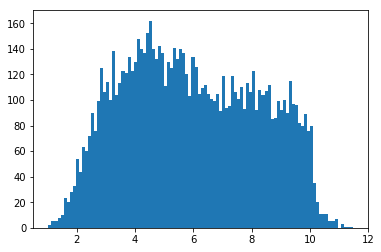

ICs round 2:
0.1234086477807088


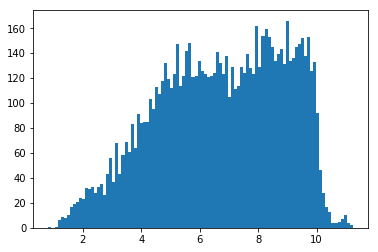

ICs round 3:
0.07546737011125129


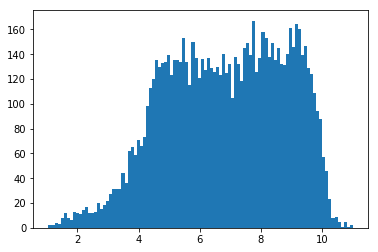

ICs round 4:
0.06216309209771763


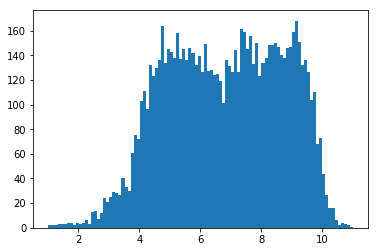

Embedding correlations:


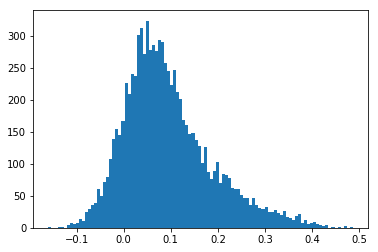

In [61]:
from matplotlib import pyplot as plt

thresh = 4

print("ICs:")
plt.hist(premotif_ics, bins=100)
print(np.mean(premotif_ics < thresh))
plt.show()

print("ICs round 2:")
plt.hist(premotifround2_ics, bins=100)
print(np.mean(premotifround2_ics < thresh))
plt.show()

print("ICs round 3:")
plt.hist(premotifround3_ics, bins=100)
print(np.mean(premotifround3_ics < thresh))
plt.show()

print("ICs round 4:")
plt.hist(premotifround4_ics, bins=100)
print(np.mean(premotifround4_ics < thresh))
plt.show()

print("Embedding correlations:")
plt.hist(correlations, bins=100)
plt.show()

#######################
FILTERING PERCENTILE: 0.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 1.0209255814552307)
Coordinate:  example:894,start:488,end:529,rc:False
Contrib scores:


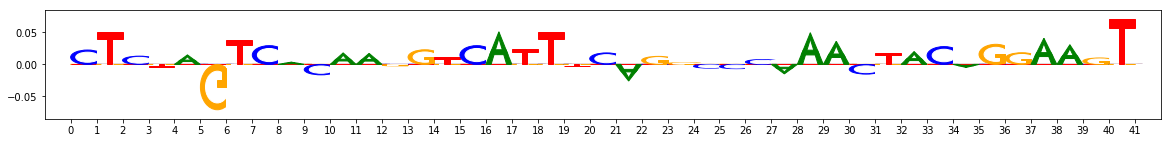

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 2.001614570617676


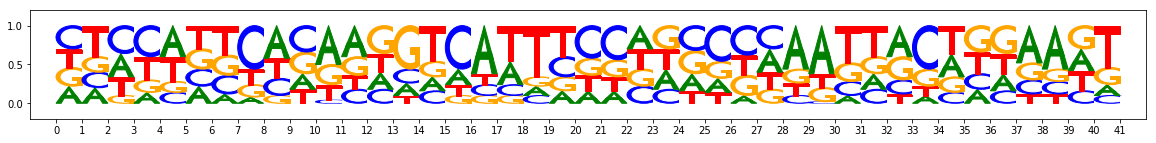

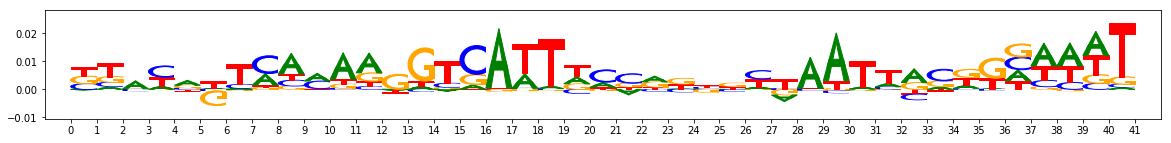

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 1.0209255814552307


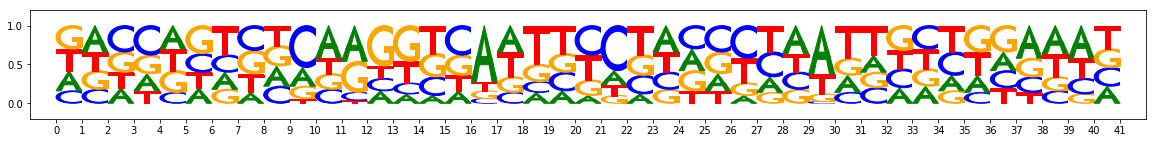

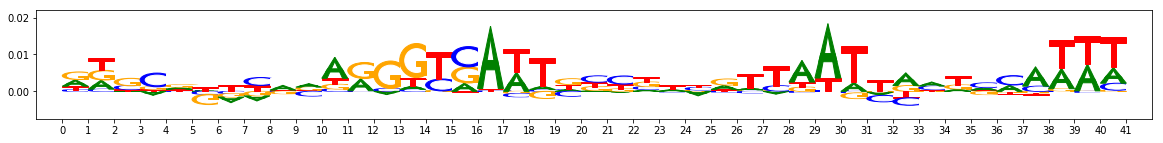

#######################
FILTERING PERCENTILE: 5.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 3.8488841354846954)
Coordinate:  example:211,start:579,end:620,rc:False
Contrib scores:


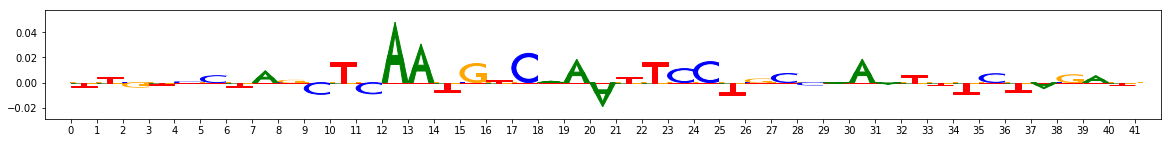

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 5.749600023031235


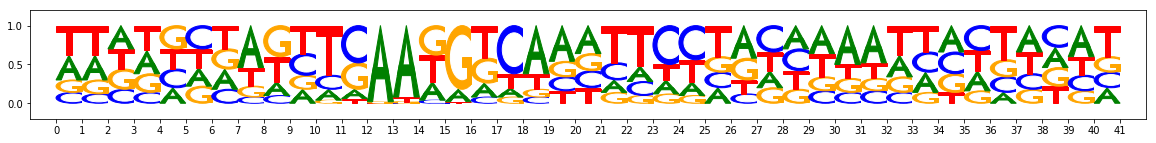

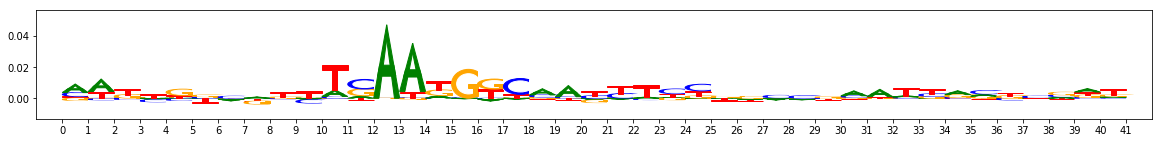

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 3.8488841354846954


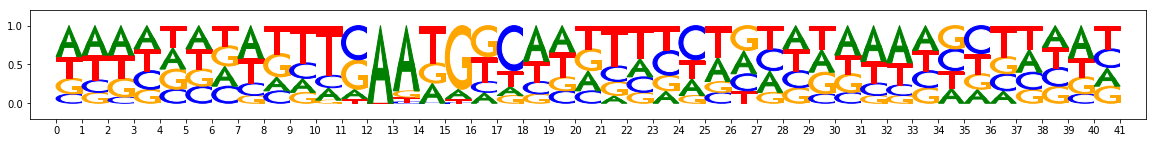

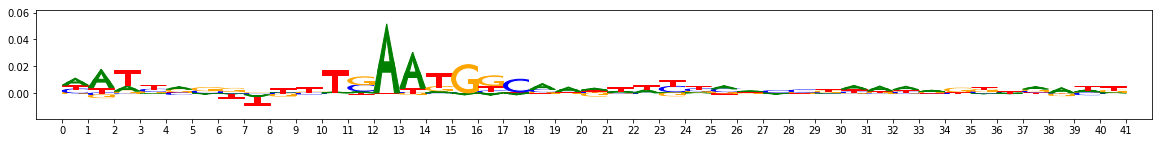

#######################
FILTERING PERCENTILE: 10.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 4.3193497359752655)
Coordinate:  example:954,start:380,end:421,rc:False
Contrib scores:


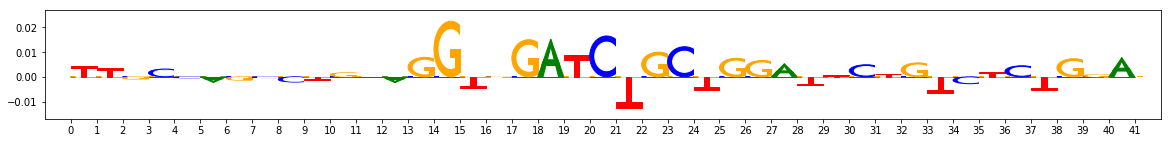

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 3.4021735191345215


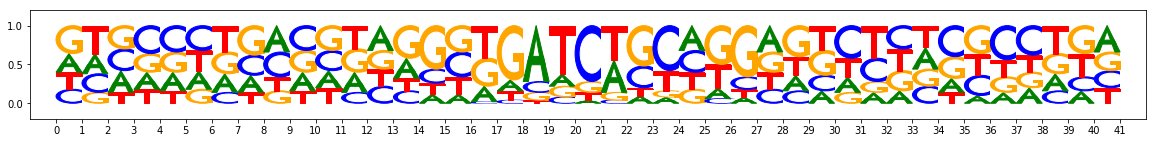

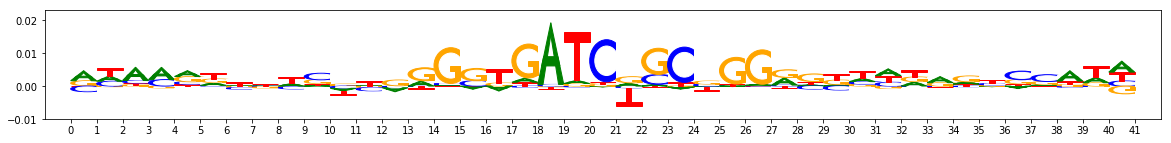

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 4.3193497359752655


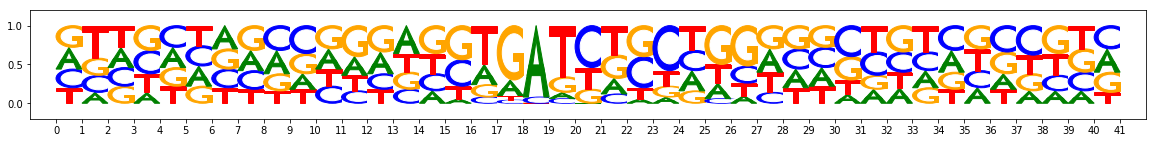

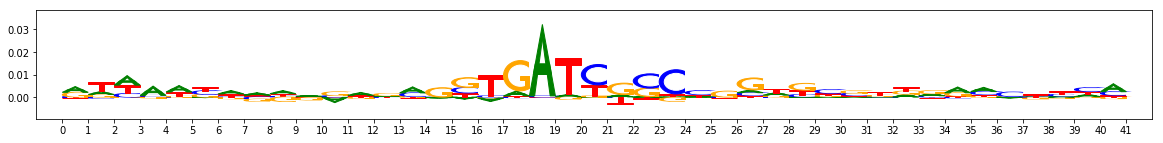

#######################
FILTERING PERCENTILE: 15.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 4.646947592496872)
Coordinate:  example:993,start:369,end:410,rc:False
Contrib scores:


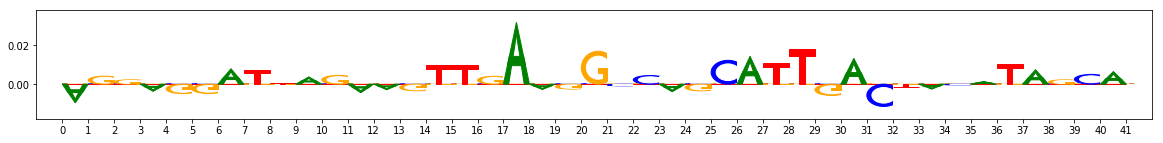

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 4.422796219587326


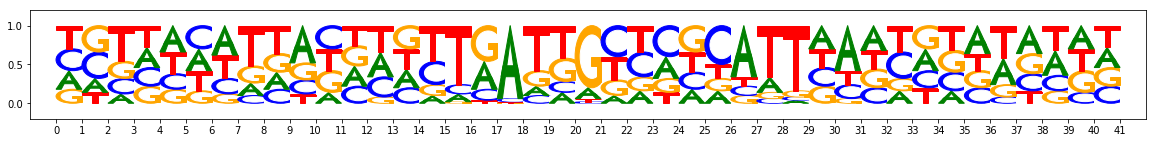

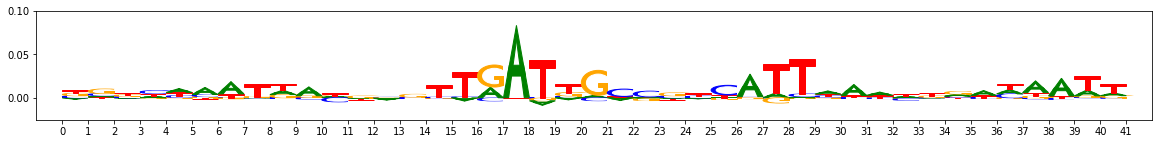

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 4.646947592496872


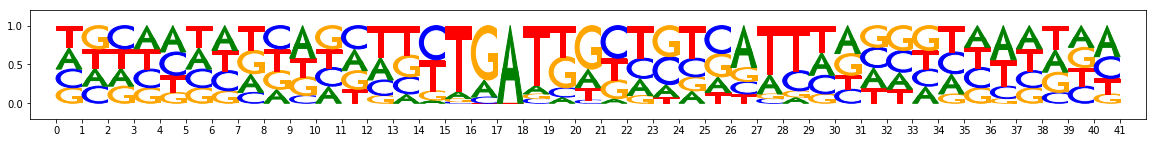

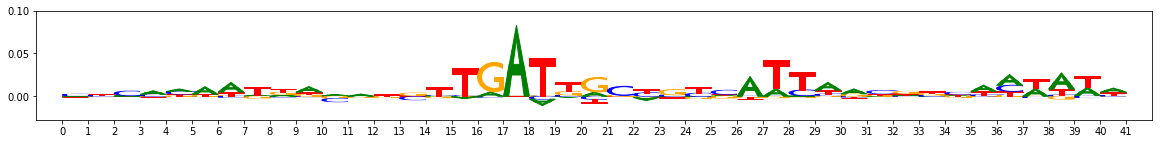

#######################
FILTERING PERCENTILE: 20.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 4.945652469992638)
Coordinate:  example:536,start:373,end:414,rc:False
Contrib scores:


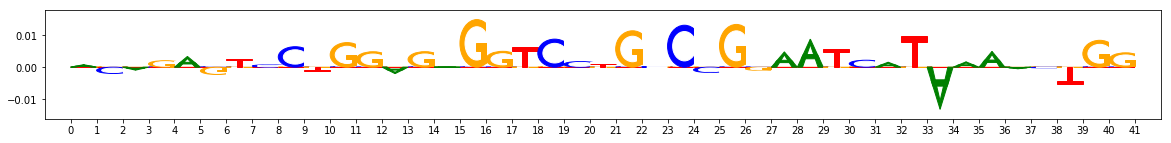

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 1.5509447753429413


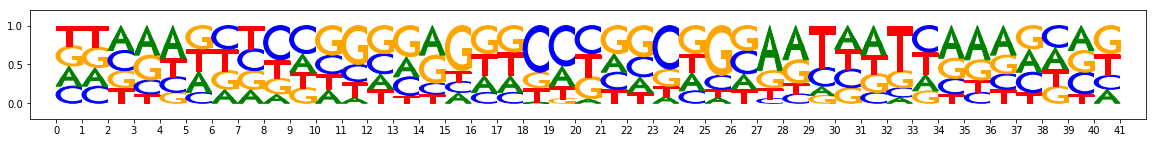

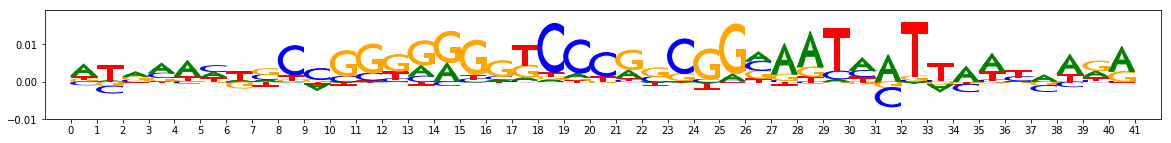

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 4.945652469992638


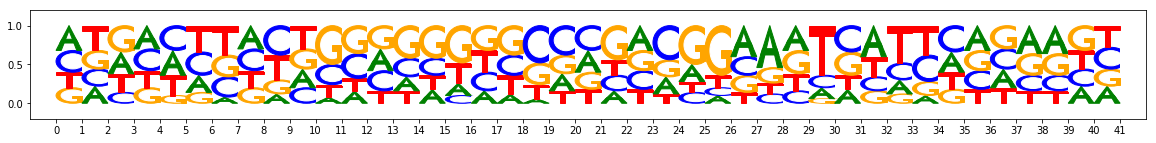

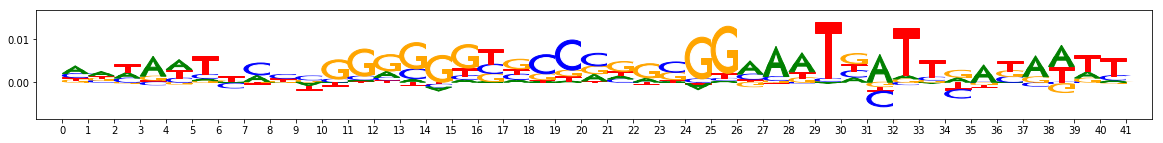

#######################
FILTERING PERCENTILE: 25.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 5.252261966466904)
Coordinate:  example:395,start:481,end:522,rc:False
Contrib scores:


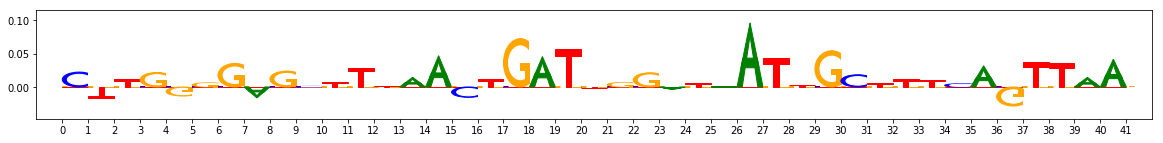

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 5.491472512483597


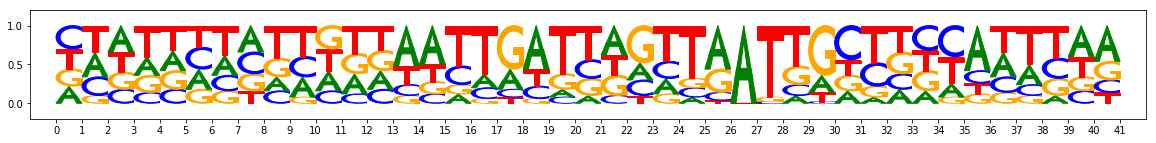

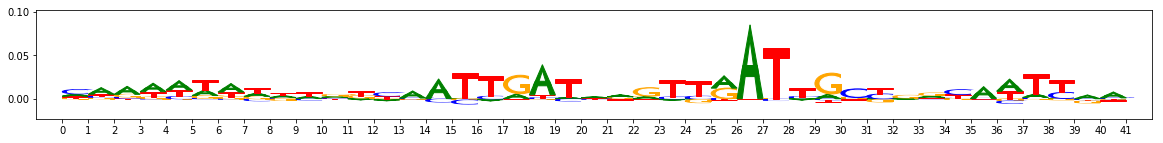

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 5.252261966466904


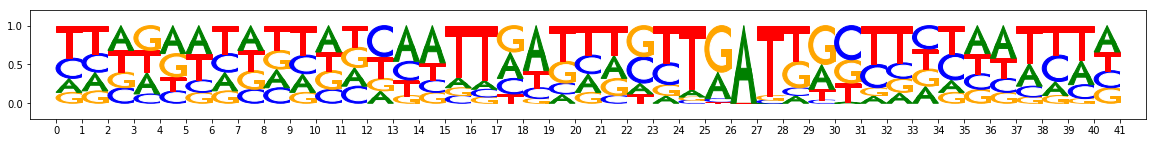

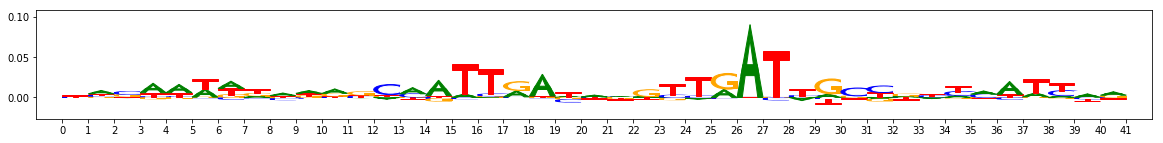

#######################
FILTERING PERCENTILE: 30.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 5.553172260522842)
Coordinate:  example:565,start:623,end:664,rc:False
Contrib scores:


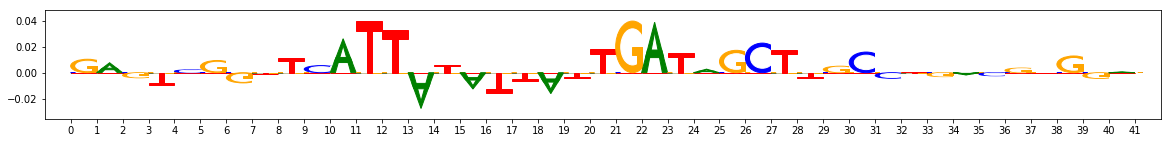

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 5.168439716100693


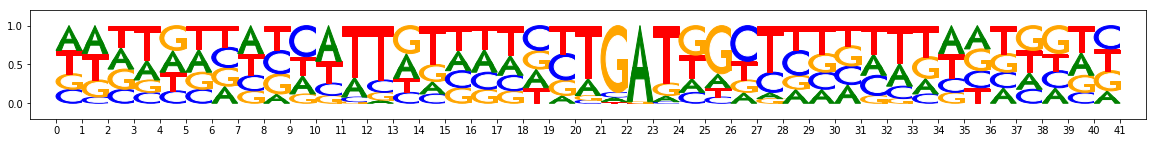

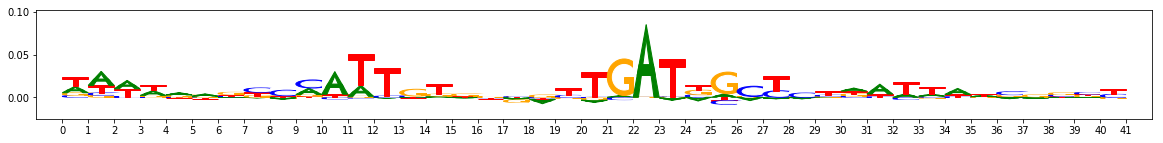

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 5.553172260522842


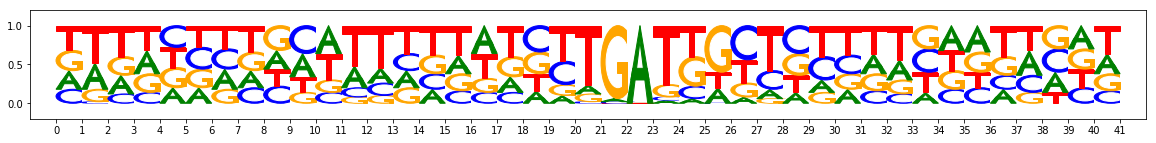

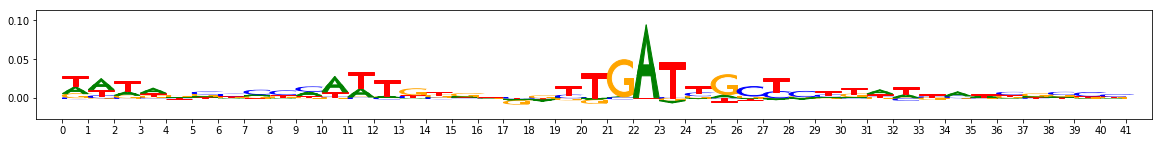

#######################
FILTERING PERCENTILE: 35.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 5.856207847595215)
Coordinate:  example:422,start:567,end:608,rc:False
Contrib scores:


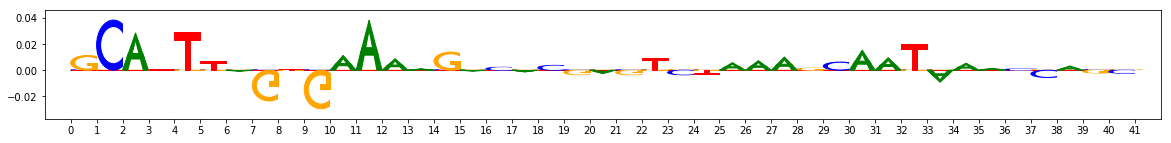

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 3.1225999891757965


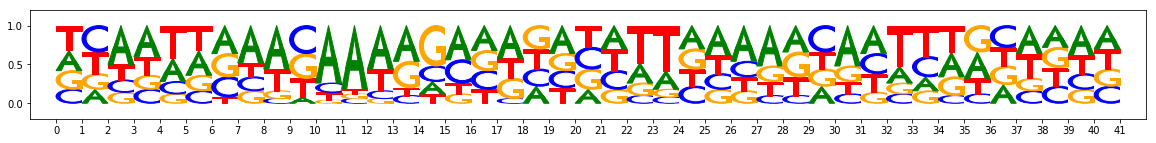

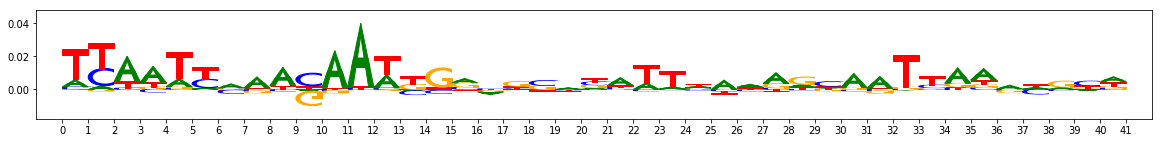

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 5.856207847595215


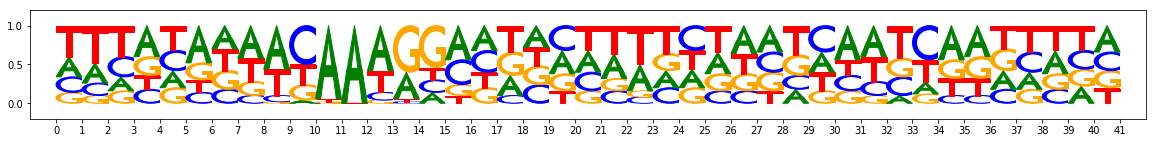

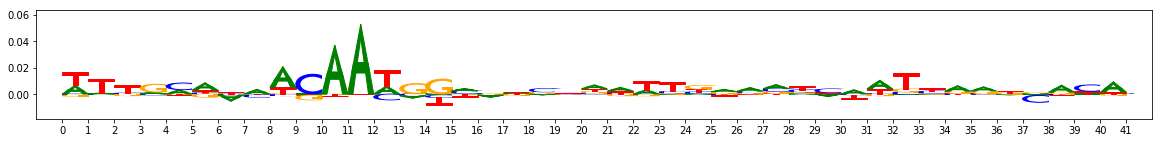

#######################
FILTERING PERCENTILE: 40.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 6.1930118799209595)
Coordinate:  example:830,start:157,end:198,rc:False
Contrib scores:


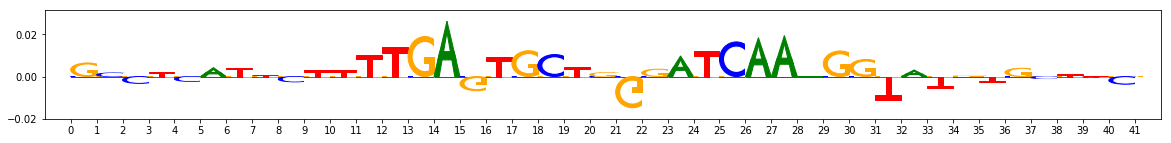

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 6.628381669521332


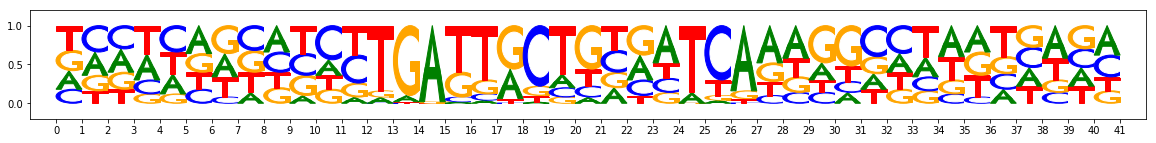

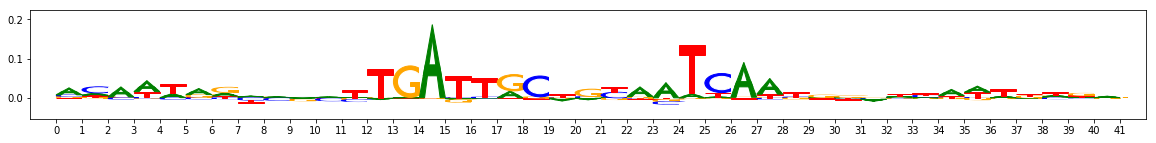

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 6.1930118799209595


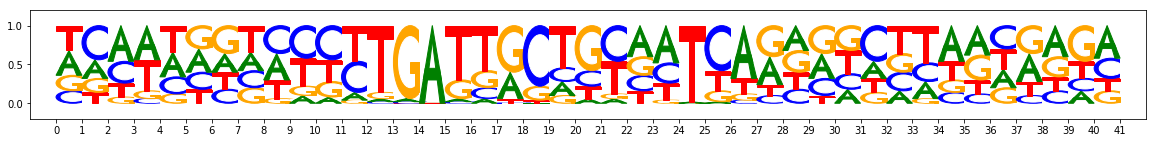

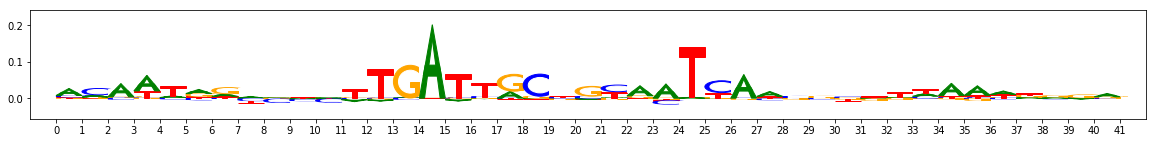

#######################
FILTERING PERCENTILE: 45.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 6.527049481868744)
Coordinate:  example:142,start:432,end:473,rc:False
Contrib scores:


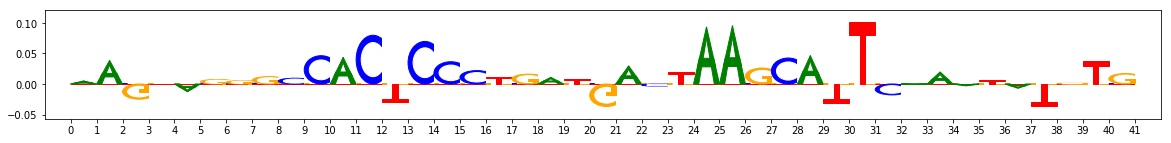

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 3.7274189591407776


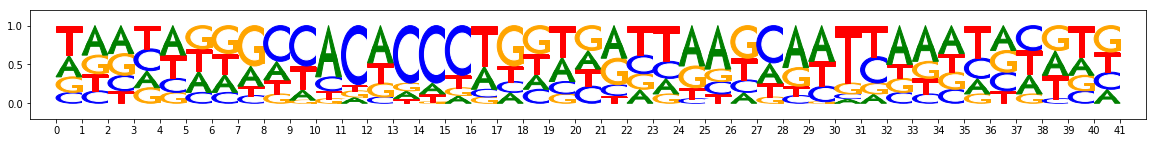

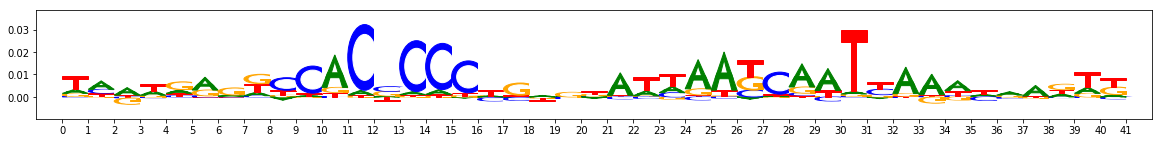

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 6.527049481868744


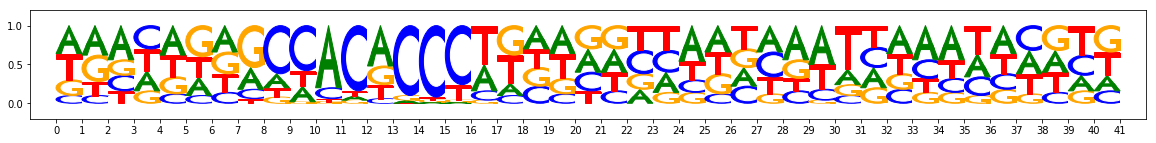

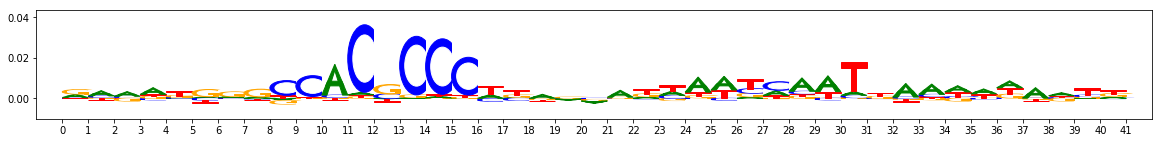

#######################
FILTERING PERCENTILE: 50.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 6.88091915845871)
Coordinate:  example:205,start:453,end:494,rc:False
Contrib scores:


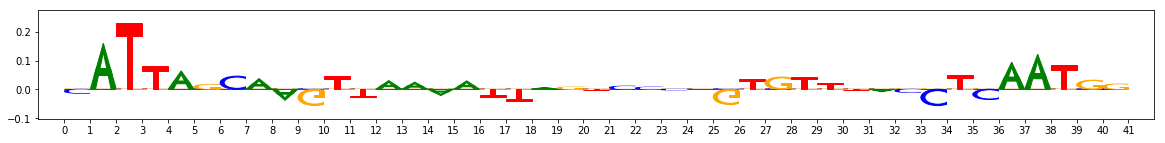

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 3.7597213685512543


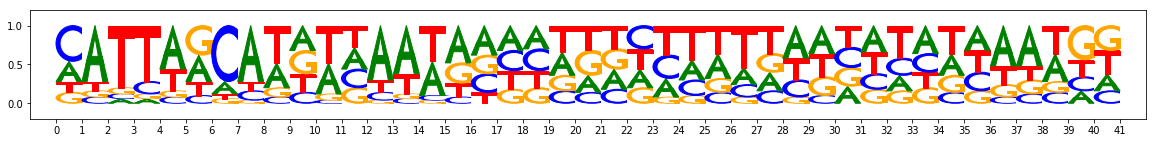

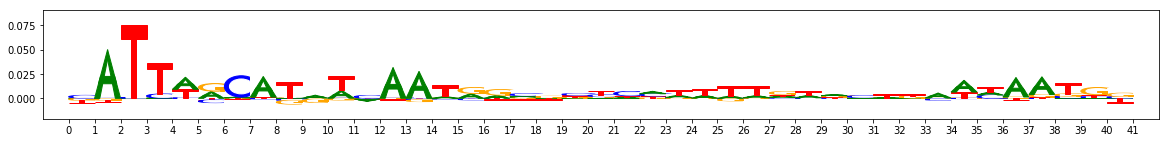

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 6.88091915845871


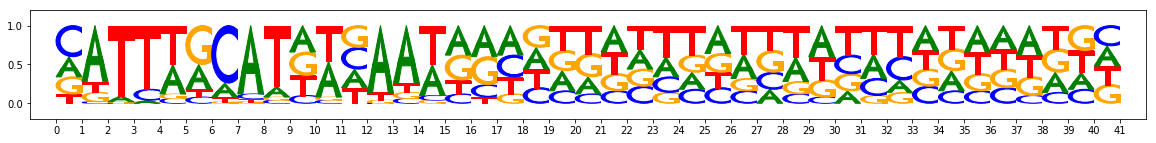

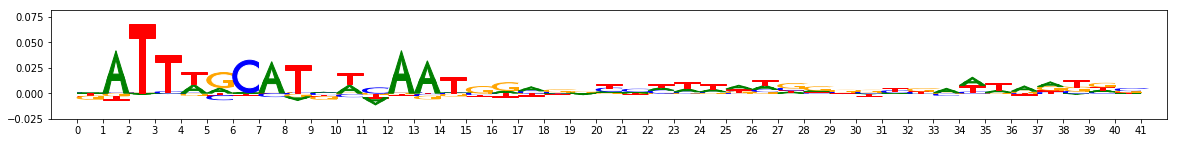

#######################
FILTERING PERCENTILE: 55.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 7.2094248831272125)
Coordinate:  example:568,start:514,end:555,rc:False
Contrib scores:


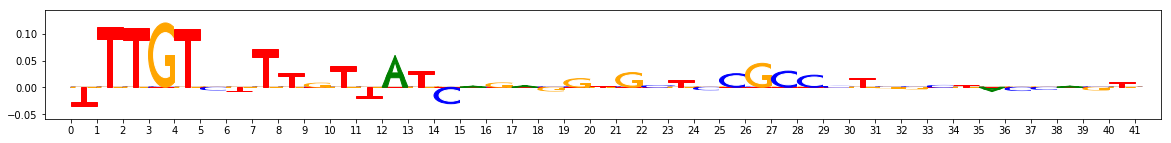

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 4.90100821852684


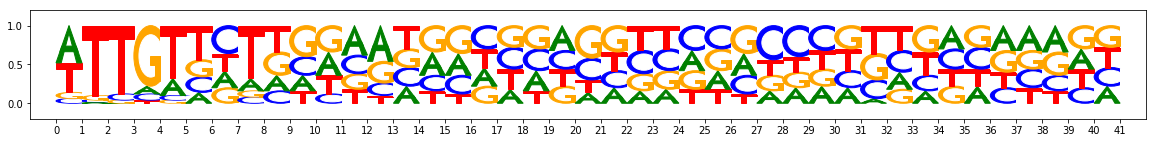

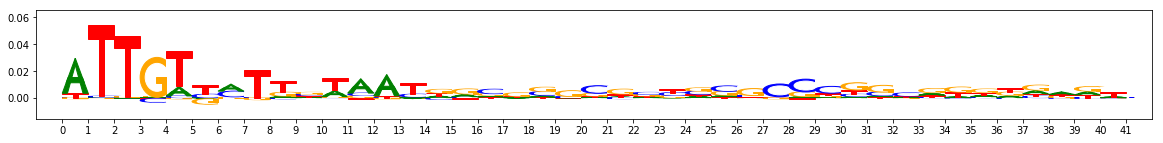

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 7.2094248831272125


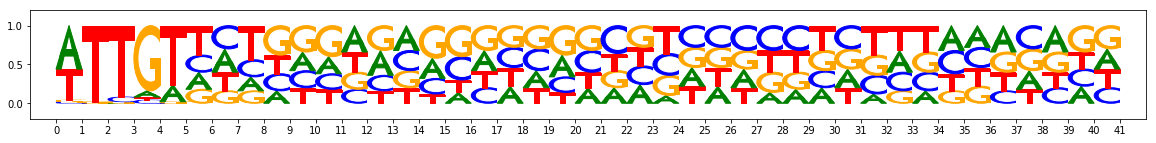

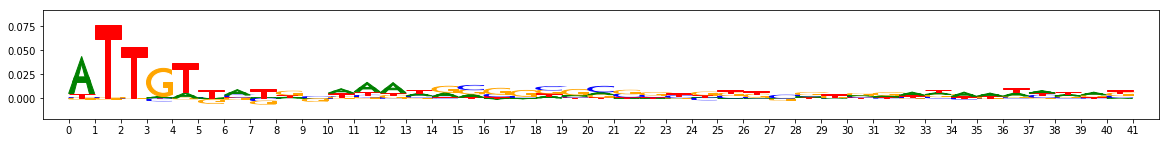

#######################
FILTERING PERCENTILE: 60.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 7.501543760299683)
Coordinate:  example:1010,start:475,end:516,rc:False
Contrib scores:


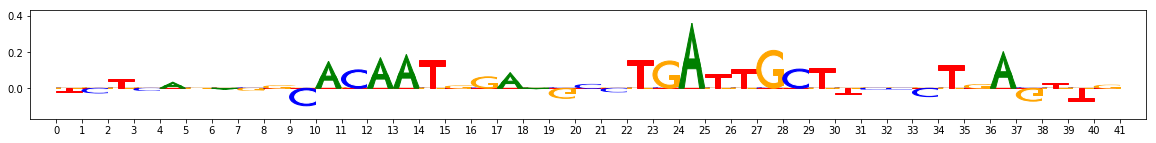

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 7.760864973068237


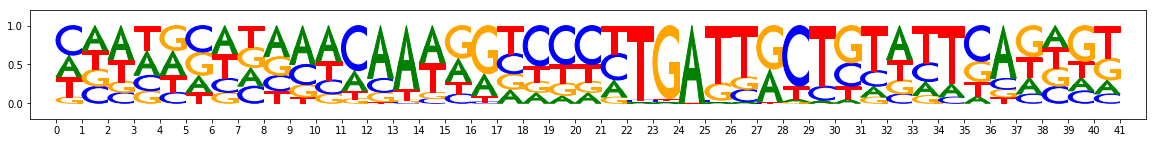

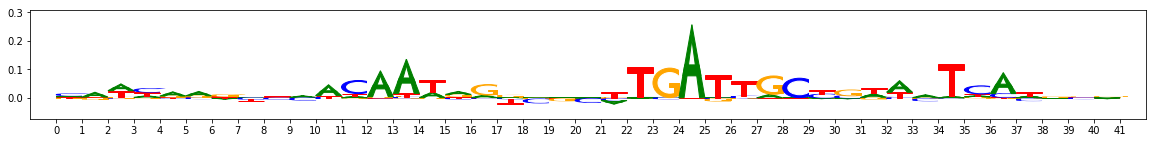

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 7.501543760299683


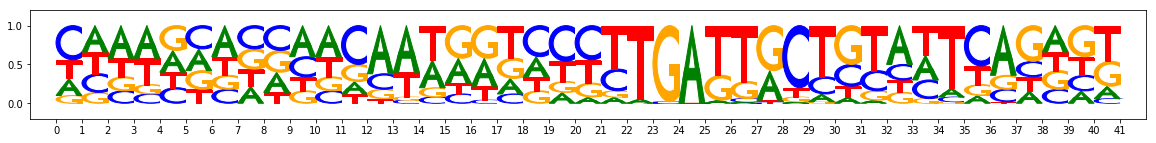

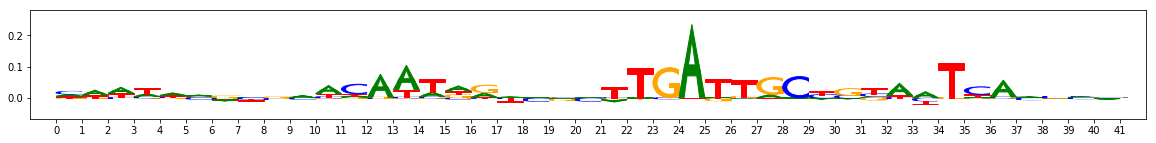

#######################
FILTERING PERCENTILE: 65.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 7.801634132862091)
Coordinate:  example:132,start:379,end:420,rc:False
Contrib scores:


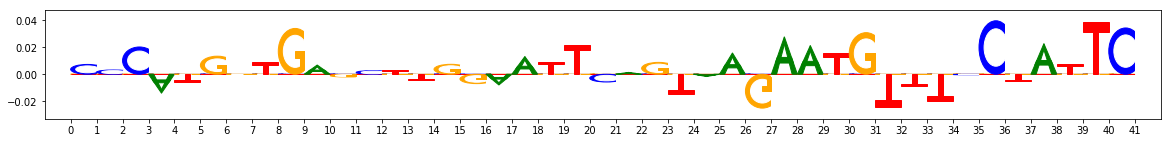

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 5.359388470649719


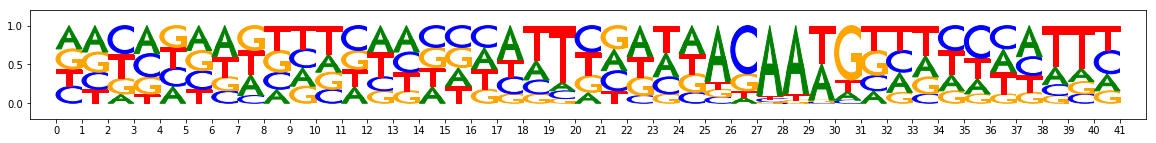

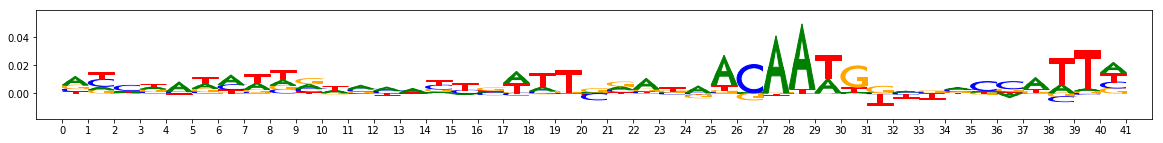

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 7.801634132862091


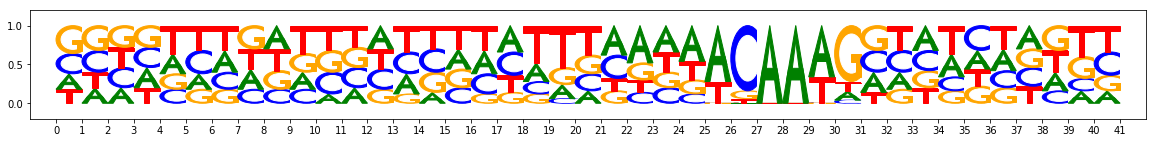

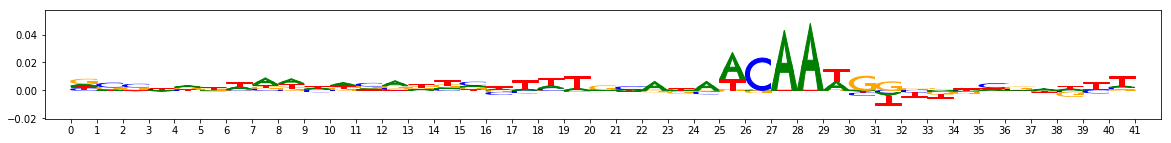

#######################
FILTERING PERCENTILE: 70.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 8.122091054916382)
Coordinate:  example:939,start:476,end:517,rc:False
Contrib scores:


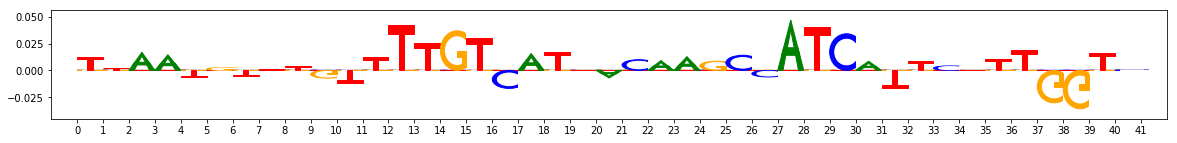

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 4.421760767698288


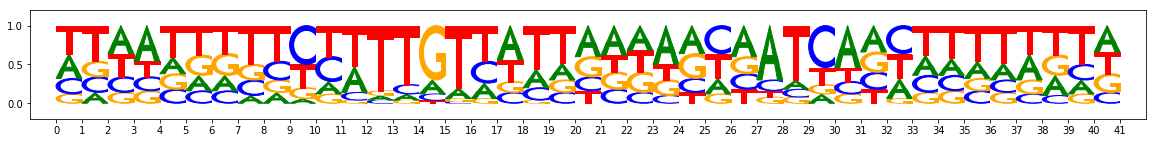

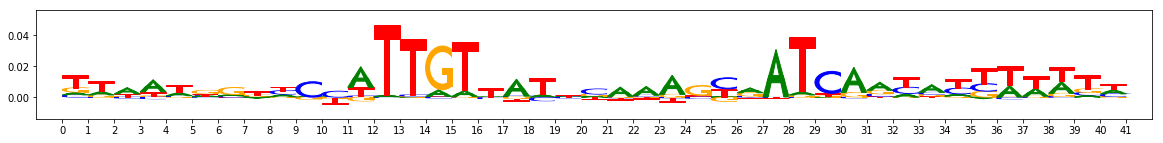

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 8.122091054916382


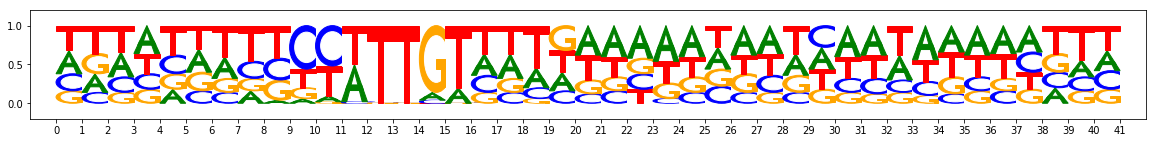

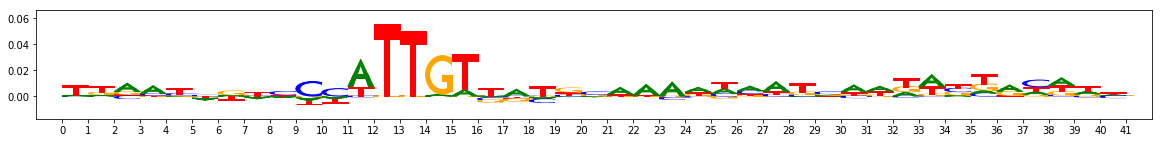

#######################
FILTERING PERCENTILE: 75.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 8.423240423202515)
Coordinate:  example:879,start:559,end:600,rc:False
Contrib scores:


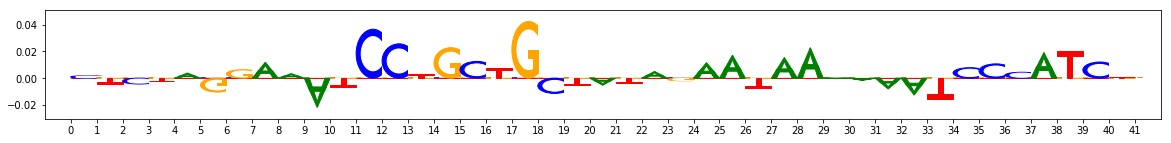

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 5.751460909843445


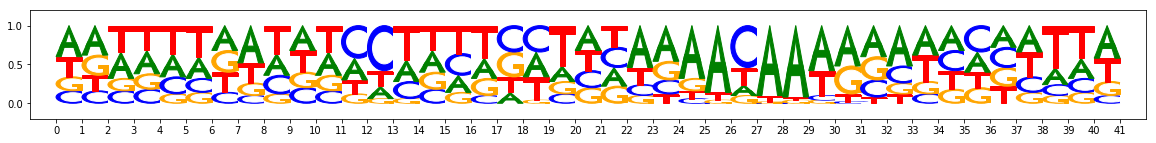

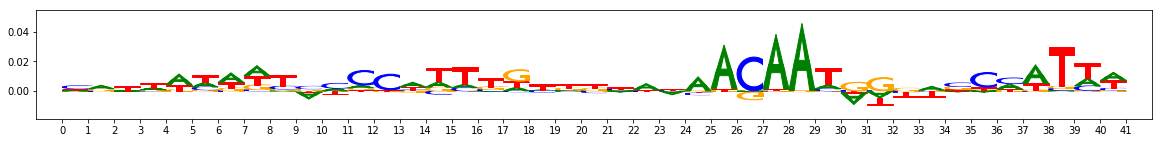

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 8.423240423202515


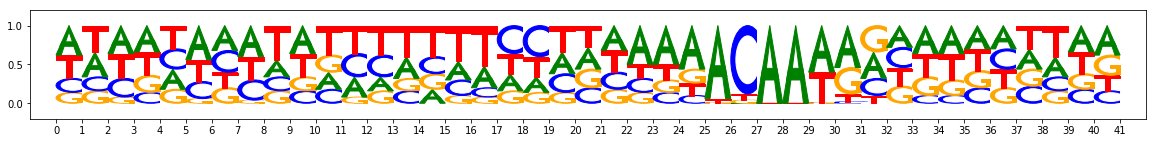

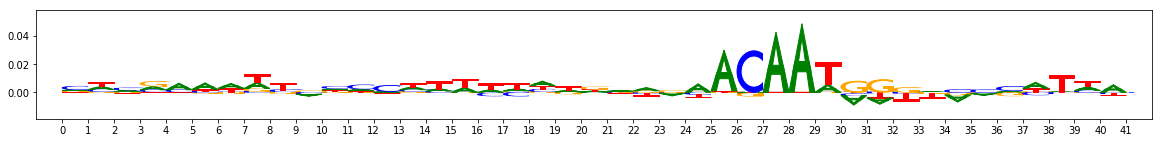

#######################
FILTERING PERCENTILE: 80.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 8.718825697898865)
Coordinate:  example:80,start:527,end:568,rc:False
Contrib scores:


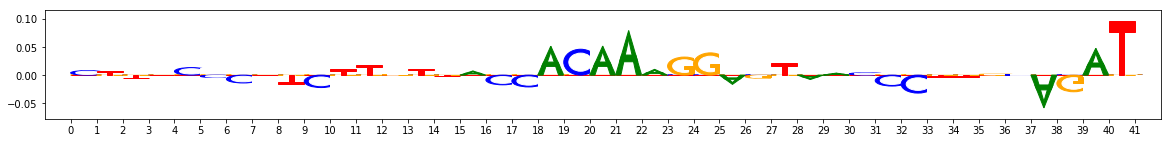

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 8.763149499893188


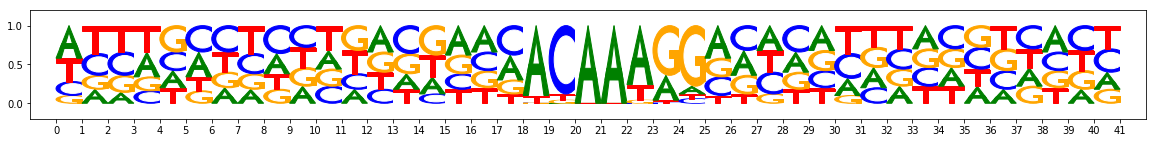

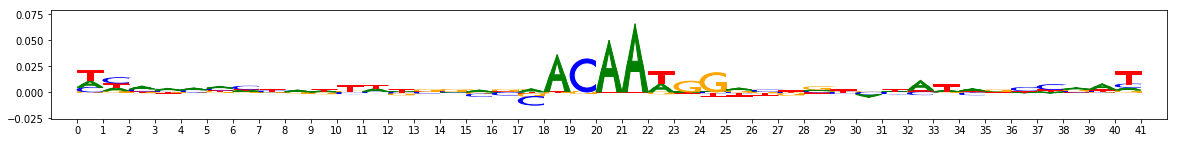

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 8.718825697898865


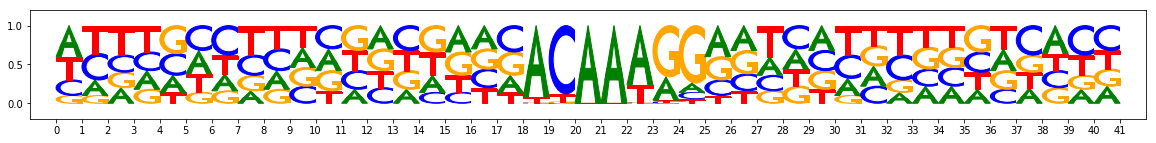

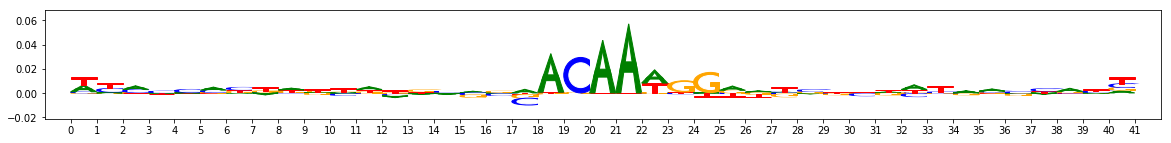

#######################
FILTERING PERCENTILE: 85.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 9.01718658208847)
Coordinate:  example:273,start:609,end:650,rc:False
Contrib scores:


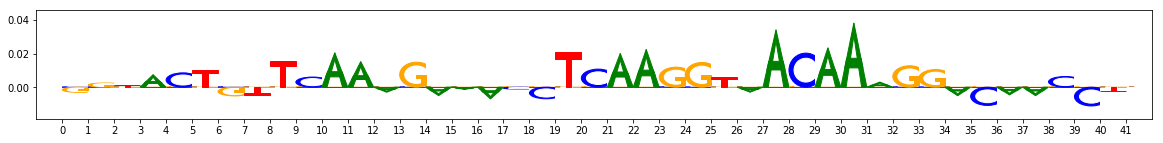

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 9.52033793926239


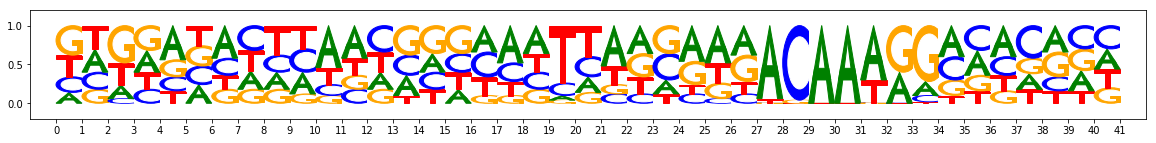

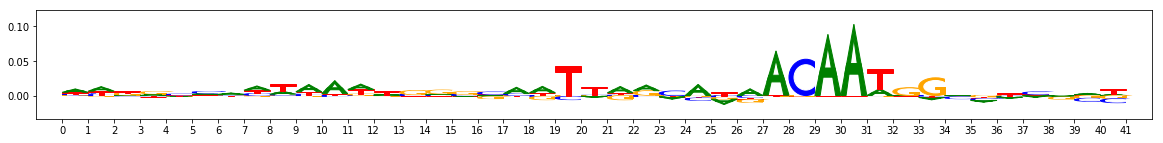

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 9.01718658208847


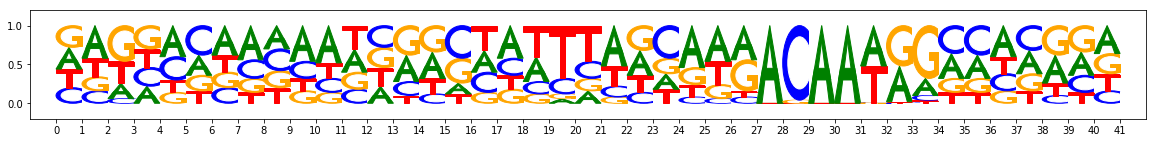

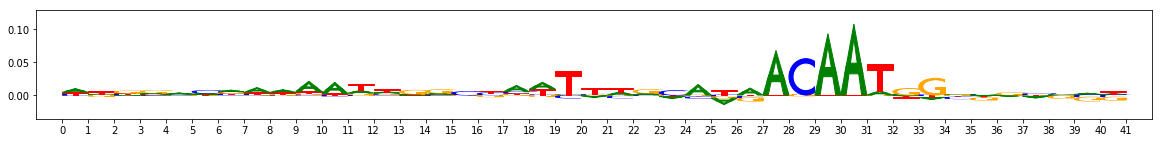

#######################
FILTERING PERCENTILE: 90.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 9.284427165985107)
Coordinate:  example:290,start:630,end:671,rc:False
Contrib scores:


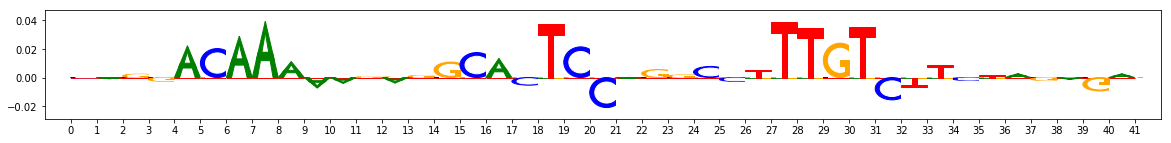

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 4.980462044477463


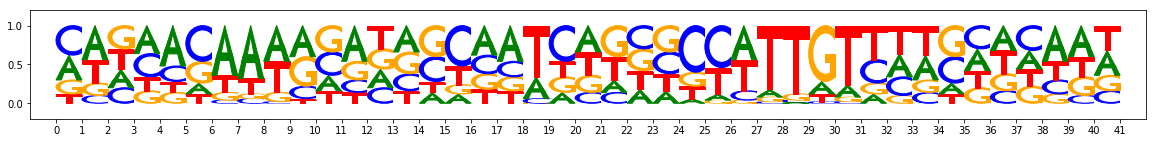

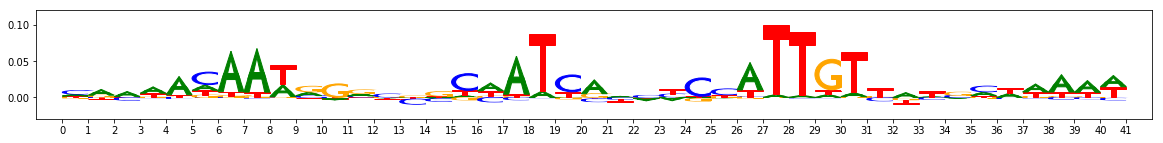

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 9.284427165985107


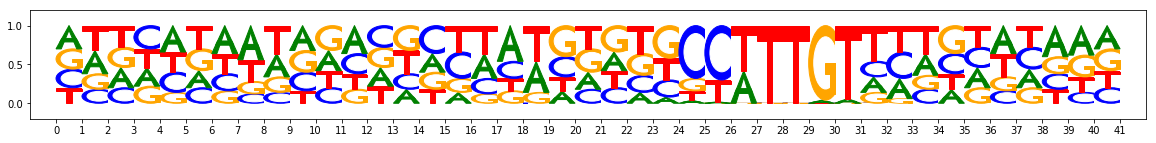

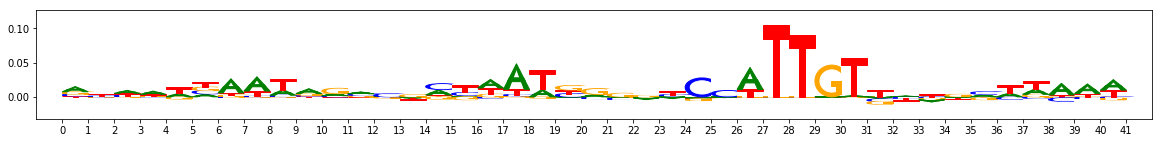

#######################
FILTERING PERCENTILE: 95.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Round 4 Information Content of 50 NN PFM (value: 9.624182343482971)
Coordinate:  example:106,start:364,end:405,rc:False
Contrib scores:


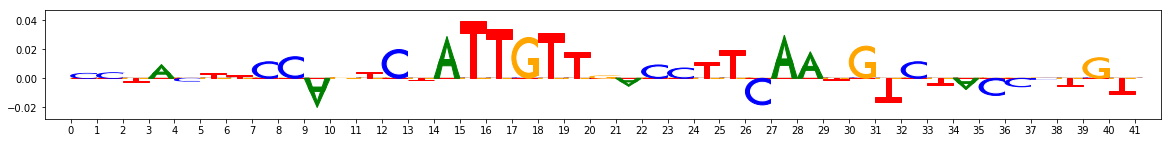

Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 9.806995153427124


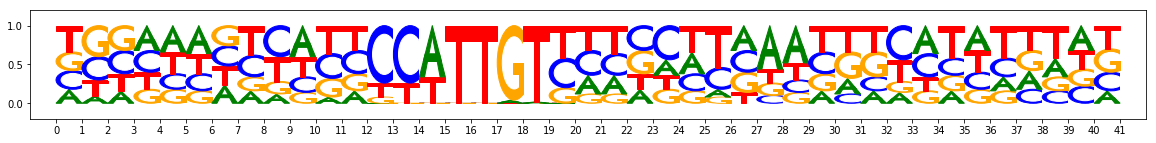

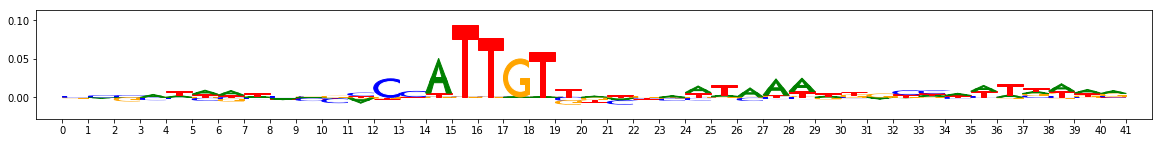

Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 9.624182343482971


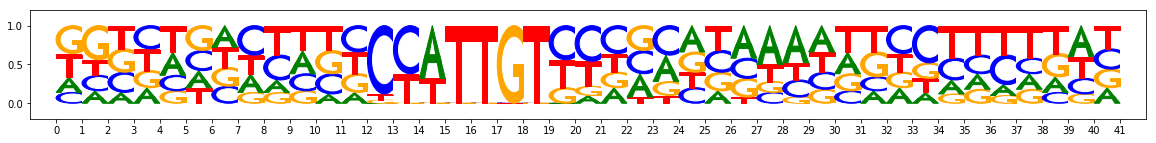

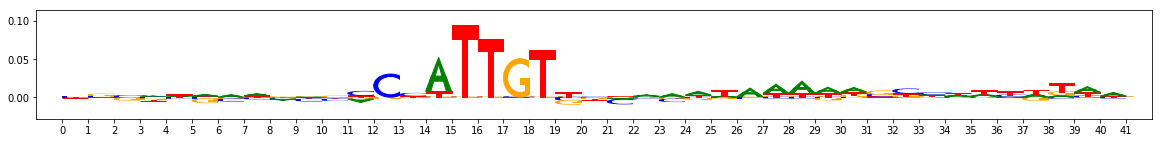

In [64]:
premotifround4_ics_argsort = np.argsort(premotifround4_ics)

from modisco.visualization import viz_sequence
steps=20 #steps to visualize
for i in range(20):
    print("#######################\nFILTERING PERCENTILE:",100*i/steps)
    print("#######################")
    argsort_idx_lookup = i*int(len(seqlets)/steps)
    premotifround4_ics_idx = premotifround4_ics_argsort[argsort_idx_lookup]
    for seqlet_idx, rankingvals, idxtypename in [
        (premotifround4_ics_idx, premotifround4_ics, "Round 4 Information Content of 50 NN PFM")]:
        print("-----------\nFiltered seqlet @ percentile, sorted via "+idxtypename+" (value: "+str(rankingvals[seqlet_idx])+")")
        print("Coordinate: ",seqlets[seqlet_idx].coor)
        print("Contrib scores:")
        viz_sequence.plot_weights(seqlets[seqlet_idx]["Nanog_profile_wn_contrib_scores"].fwd)
        print("Round1 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC "+str(premotif_ics[seqlet_idx]))
        viz_sequence.plot_weights(premotif_avgseqlets[seqlet_idx]["sequence"].fwd)
        viz_sequence.plot_weights(premotif_avgseqlets[seqlet_idx]["Nanog_profile_wn_contrib_scores"].fwd)
        print("Round4 PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC "+str(premotifround4_ics[seqlet_idx]))
        viz_sequence.plot_weights(premotifround2_avgseqlets[seqlet_idx]["sequence"].fwd)
        viz_sequence.plot_weights(premotifround2_avgseqlets[seqlet_idx]["Nanog_profile_wn_contrib_scores"].fwd)
    
    
#for i in premotif_ics_argsort[::int(len(seqlets)/50)]:
#    print(premotif_ics_argsort[i],
#          premotif_ics[premotif_ics_argsort[i]])
#    viz_sequence.plot_weights(
#        seqlets[premotif_ics_argsort[i]]
#               ["Nanog_profile_wn_contrib_scores"].fwd)

In [29]:
#run a tsne viz on the affinities.
aff_to_dist_mat = modisco.affinitymat.transformers.AffToDistViaInvLogistic()
dense_nn_affmat = reconstitute_dense_affmat(
                                    sparse_affmat_withargmax=sparse_nn_affmat_withargmax,
                                    seqlet_neighbors=seqlet_neighbors)
dense_nn_distmat = aff_to_dist_mat(dense_nn_affmat)

In [33]:
from sklearn.manifold import TSNE
dense_nn_distmat_embedding = TSNE(verbose=2, perplexity=30, metric="precomputed").fit_transform(dense_nn_distmat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8719 samples in 0.051s...
[t-SNE] Computed neighbors for 8719 samples in 0.819s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8719
[t-SNE] Computed conditional probabilities for sample 2000 / 8719
[t-SNE] Computed conditional probabilities for sample 3000 / 8719
[t-SNE] Computed conditional probabilities for sample 4000 / 8719
[t-SNE] Computed conditional probabilities for sample 5000 / 8719
[t-SNE] Computed conditional probabilities for sample 6000 / 8719
[t-SNE] Computed conditional probabilities for sample 7000 / 8719
[t-SNE] Computed conditional probabilities for sample 8000 / 8719
[t-SNE] Computed conditional probabilities for sample 8719 / 8719
[t-SNE] Mean sigma: 0.318136
[t-SNE] Computed conditional probabilities in 0.358s
[t-SNE] Iteration 50: error = 92.5316010, gradient norm = 0.0000064 (50 iterations in 3.768s)
[t-SNE] Iteration 100: error = 92.3685989, gradient norm = 0.0061796 (50 iterations in 4.

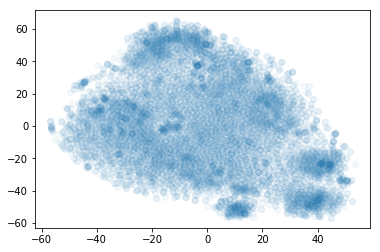

In [41]:
from matplotlib import pyplot as plt
plt.scatter(*zip(*dense_nn_distmat_embedding), alpha=0.05)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8719 samples in 0.061s...
[t-SNE] Computed neighbors for 8719 samples in 0.775s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8719
[t-SNE] Computed conditional probabilities for sample 2000 / 8719
[t-SNE] Computed conditional probabilities for sample 3000 / 8719
[t-SNE] Computed conditional probabilities for sample 4000 / 8719
[t-SNE] Computed conditional probabilities for sample 5000 / 8719
[t-SNE] Computed conditional probabilities for sample 6000 / 8719
[t-SNE] Computed conditional probabilities for sample 7000 / 8719
[t-SNE] Computed conditional probabilities for sample 8000 / 8719
[t-SNE] Computed conditional probabilities for sample 8719 / 8719
[t-SNE] Mean sigma: 0.267740
[t-SNE] Computed conditional probabilities in 0.375s
[t-SNE] Iteration 50: error = 92.8614655, gradient norm = 0.0029600 (50 iterations in 5.521s)
[t-SNE] Iteration 100: error = 88.0847168, gradient norm = 0.0012540 (50 iterations in 8.

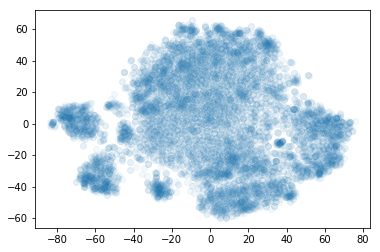

In [68]:
#run a tsne viz on the affinities.
usingpremotifsround1_dense_nn_affmat = reconstitute_dense_affmat(
                                    sparse_affmat_withargmax=usingpremotifsround1_sparse_nn_affmat_withargmax,
                                    seqlet_neighbors=seqlet_neighbors)
dense_nn_distmat = aff_to_dist_mat(usingpremotifsround1_dense_nn_affmat)
usingpremotifsround1_dense_nn_distmat_embedding = TSNE(verbose=2, perplexity=30, metric="precomputed").fit_transform(dense_nn_distmat)

from matplotlib import pyplot as plt
plt.scatter(*zip(*usingpremotifsround1_dense_nn_distmat_embedding), alpha=0.05)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8719 samples in 0.054s...
[t-SNE] Computed neighbors for 8719 samples in 0.751s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8719
[t-SNE] Computed conditional probabilities for sample 2000 / 8719
[t-SNE] Computed conditional probabilities for sample 3000 / 8719
[t-SNE] Computed conditional probabilities for sample 4000 / 8719
[t-SNE] Computed conditional probabilities for sample 5000 / 8719
[t-SNE] Computed conditional probabilities for sample 6000 / 8719
[t-SNE] Computed conditional probabilities for sample 7000 / 8719
[t-SNE] Computed conditional probabilities for sample 8000 / 8719
[t-SNE] Computed conditional probabilities for sample 8719 / 8719
[t-SNE] Mean sigma: 0.269850
[t-SNE] Computed conditional probabilities in 0.355s
[t-SNE] Iteration 50: error = 93.4284744, gradient norm = 0.0033141 (50 iterations in 5.866s)
[t-SNE] Iteration 100: error = 85.0929337, gradient norm = 0.0017714 (50 iterations in 6.

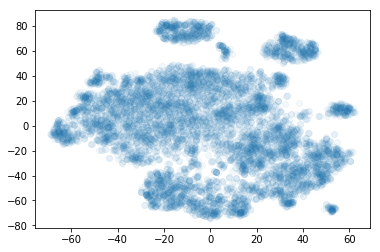

In [69]:
#run a tsne viz on the affinities.
usingpremotifsround2_dense_nn_affmat = reconstitute_dense_affmat(
                                    sparse_affmat_withargmax=usingpremotifsround2_sparse_nn_affmat_withargmax,
                                    seqlet_neighbors=seqlet_neighbors)
dense_nn_distmat = aff_to_dist_mat(usingpremotifsround2_dense_nn_affmat)
usingpremotifsround2_dense_nn_distmat_embedding = TSNE(verbose=2, perplexity=30, metric="precomputed").fit_transform(dense_nn_distmat)

from matplotlib import pyplot as plt
plt.scatter(*zip(*usingpremotifsround2_dense_nn_distmat_embedding), alpha=0.05)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8719 samples in 0.050s...
[t-SNE] Computed neighbors for 8719 samples in 0.743s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8719
[t-SNE] Computed conditional probabilities for sample 2000 / 8719
[t-SNE] Computed conditional probabilities for sample 3000 / 8719
[t-SNE] Computed conditional probabilities for sample 4000 / 8719
[t-SNE] Computed conditional probabilities for sample 5000 / 8719
[t-SNE] Computed conditional probabilities for sample 6000 / 8719
[t-SNE] Computed conditional probabilities for sample 7000 / 8719
[t-SNE] Computed conditional probabilities for sample 8000 / 8719
[t-SNE] Computed conditional probabilities for sample 8719 / 8719
[t-SNE] Mean sigma: 0.272174
[t-SNE] Computed conditional probabilities in 0.358s
[t-SNE] Iteration 50: error = 93.1927185, gradient norm = 0.0113080 (50 iterations in 4.070s)
[t-SNE] Iteration 100: error = 83.0941315, gradient norm = 0.0022359 (50 iterations in 3.

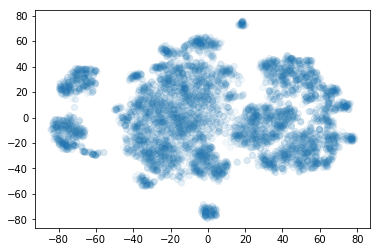

In [66]:
#run a tsne viz on the affinities.
usingpremotifsround3_dense_nn_affmat = reconstitute_dense_affmat(
                                    sparse_affmat_withargmax=usingpremotifsround3_sparse_nn_affmat_withargmax,
                                    seqlet_neighbors=seqlet_neighbors)
dense_nn_distmat = aff_to_dist_mat(usingpremotifsround3_dense_nn_affmat)

usingpremotifsround3_dense_nn_distmat_embedding = TSNE(verbose=2, perplexity=30, metric="precomputed").fit_transform(dense_nn_distmat)

from matplotlib import pyplot as plt
plt.scatter(*zip(*usingpremotifsround3_dense_nn_distmat_embedding), alpha=0.05)
plt.show()